# Reproducible SLURM jobs from a Jupyter Notebook

For Jupyter notebook and Python lover, we can start automating our workflows by creating notebooks containing any number of pre-processing steps, batch scripts, monitoring commands and post-processing steps to be performed during and after job execution. 

This can make HPC workflows more reproducible and shareable, and ready-made notebooks can make it easier, for example, for new reseacher students to get started.

In this post, instead of manage jobs via SSH terminal or open on demand web portal, we demo how to use __Slurm Magics__ to do the interactive analysis and Slurm job management without leaving from Jupyter Notebook.

## SLURM magics

- __Slurm magic__ developed by National Energy Research Scientific Computing (NERSC)[1]
- The slurm magic command will interact with __Slurm workload__ management, for short, it is Slurm command wrapper.
- Each command implement by __fork or spawned new __subprocess__ then output is captured and show on notebook with UTF-8 decoding.


## Using SLURM magics

With Ondemand Exascale webportal you can login and select --> Interactive Apps --> Jupyter Notebook

http://exascale.mahidol.ac.th

Assume, you connect to exascale.mahidol.ac.th portal, and create Jupyter Notebook server.

In new jupyter notebook, we need to load IPython slurm extension:

In [ ]:
pip install git+https://github.com/NERSC/slurm-magic.git


In [1]:
%load_ext slurm_magic

From now on, we can interact with Slurm workload manager,without VPN SSH

In [2]:
%lsmagic    

Available line magics:
%alias  %alias_magic  %autoawait  %autocall  %automagic  %autosave  %bookmark  %cat  %cd  %clear  %colors  %conda  %config  %connect_info  %cp  %debug  %dhist  %dirs  %doctest_mode  %ed  %edit  %env  %gui  %hist  %history  %killbgscripts  %ldir  %less  %lf  %lk  %ll  %load  %load_ext  %loadpy  %logoff  %logon  %logstart  %logstate  %logstop  %ls  %lsmagic  %lx  %macro  %magic  %man  %matplotlib  %mkdir  %more  %mv  %notebook  %page  %pastebin  %pdb  %pdef  %pdoc  %pfile  %pinfo  %pinfo2  %pip  %popd  %pprint  %precision  %prun  %psearch  %psource  %pushd  %pwd  %pycat  %pylab  %qtconsole  %quickref  %recall  %rehashx  %reload_ext  %rep  %rerun  %reset  %reset_selective  %rm  %rmdir  %run  %sacct  %sacctmgr  %salloc  %sattach  %save  %sbatch  %sbcast  %sc  %scancel  %scontrol  %sdiag  %set_env  %sinfo  %slurm  %smap  %sprio  %squeue  %sreport  %srun  %sshare  %sstat  %store  %strigger  %sview  %sx  %system  %tb  %time  %timeit  %unalias  %unload_ext  %who  %who_ls

In [3]:
import warnings
warnings.filterwarnings('ignore')

## Submit GROMACS job and analysis results on the fly

To demo how to submit job for __ simulations of biological macromolecules__ GROMACS package example for Lysozyme[3] in water is used.

In [ ]:
!git clone https://github.com/snitgit/Slurm-jupyter-notebook.git

In [4]:
cd Slurm-jupyter-notebook/

/home/snit.san/slurm-magic/Slurm-jupyter-notebook


In [5]:
ls

0-setup.ipynb  2-slurm-analysis.ipynb  cities/       img/
1-intro.ipynb  3-parallel.ipynb        gromacs_job/


In [6]:
%cd gromacs_job/

/home/snit.san/slurm-magic/Slurm-jupyter-notebook/gromacs_job


In [7]:
sinfo

,PARTITION,AVAIL,TIMELIMIT,NODES,STATE,NODELIST
0,batch*,up,420-00:00:,1,mix,omega
1,batch*,up,420-00:00:,3,idle,"tensorcore,turing,zeta"


Use __%sbatch__ to submit job on next cell

In [8]:
squeue

,JOBID,PARTITION,NAME,USER,ST,TIME,NODES,NODELIST(REASON)
0,6599,batch,sys-dash,snit.san,R,1:13,1,omega
1,5890,batch,bash,tantip.a,R,9-02:06:59,1,omega


In [35]:
%%sbatch
#!/bin/bash -l
#SBATCH -A ict
#SBATCH -N 1
#SBATCH -t 01:05:00
#SBATCH -J gromacs

#SBATCH --gres=gpu:2

#SBATCH -w, --nodelist=zeta
# change temp or log to your folder
export SINGULARITY_TMPDIR=/home/snit.san/tmp
export CUDA_MPS_LOG_DIRECTORY=/home/snit.san/var/log/mvidia-mps
module use /shared/software/software/mulabs

module load hpcx-ompi
module load gromacs
gmx grompp -f npt.mdp -c start.gro -p topol.top -maxwarn 100
gmx mdrun -ntmpi 1 -ntomp 40 -v -pin on -nb gpu --pme gpu -noconfout -s topol.tpr -deffnm npt

'Submitted batch job 6611\n'

In [36]:
%squeue -u snit.san

,JOBID,PARTITION,NAME,USER,ST,TIME,NODES,NODELIST(REASON)
0,6599,batch,sys-dash,snit.san,R,44:26,1,omega
1,6611,batch,gromacs,snit.san,R,0:03,1,zeta


 Gromacs utility can be used to extract information from the binary output files.
 
 To run it, we write shell commands into a code cell containing the __%%bash__ magic to let Jupyter execute a bash script. In our case, we extract time-dependent values of __temperature, density and pressure__ from the simulation[4].

In [41]:
%%bash
module use /shared/software/software/mulabs
module load gromacs/2021
echo "Temperature" | gmx energy -f npt.edr -o temperature.xvg
echo "Density" | gmx energy -f npt.edr -o density.xvg
echo "Pressure" | gmx  energy -f npt.edr -o pressure.xvg


Statistics over 161501 steps [ 0.0000 through 323.0000 ps ], 1 data sets
All statistics are over 16151 points

Energy                      Average   Err.Est.       RMSD  Tot-Drift
-------------------------------------------------------------------------------
Temperature                 300.024      0.069    1.66438   0.354538  (K)

Statistics over 162501 steps [ 0.0000 through 325.0000 ps ], 1 data sets
All statistics are over 16251 points

Energy                      Average   Err.Est.       RMSD  Tot-Drift
-------------------------------------------------------------------------------
Density                     1016.21       0.21    2.37206  -0.433522  (kg/m^3)

Statistics over 163501 steps [ 0.0000 through 327.0000 ps ], 1 data sets
All statistics are over 16351 points

Energy                      Average   Err.Est.       RMSD  Tot-Drift
-------------------------------------------------------------------------------
Pressure                    1.06924       0.18    140.482   0.19

INFO:    Using cached SIF image
     :-) GROMACS - gmx energy, 2021-dev-20210128-6a0b0c4-dirty-unknown (-:

                            GROMACS is written by:
     Andrey Alekseenko              Emile Apol              Rossen Apostolov     
         Paul Bauer           Herman J.C. Berendsen           Par Bjelkmar       
       Christian Blau           Viacheslav Bolnykh             Kevin Boyd        
     Aldert van Buuren           Rudi van Drunen             Anton Feenstra      
    Gilles Gouaillardet             Alan Gray               Gerrit Groenhof      
       Anca Hamuraru            Vincent Hindriksen          M. Eric Irrgang      
      Aleksei Iupinov           Christoph Junghans             Joe Jordan        
    Dimitrios Karkoulis            Peter Kasson                Jiri Kraus        
      Carsten Kutzner              Per Larsson              Justin A. Lemkul     
       Viveca Lindahl            Magnus Lundborg             Erik Marklund       
        Pascal Merz  

define a function to extract data from the processed Gromacs xvg files

In [38]:
def get_prop(prop):
    """Extract system property (Temperature, Pressure, Potential, or Density)
    from a GROMACS xvg file. Returns lists of time and property."""

    x = []
    y = []

    f_prop = open("%s.xvg" % prop, 'r')
    for line in f_prop:
        if line[0] == '#' or line[0] == '@':
            continue
        content = line.split()
        x.append(float(content[0]))
        y.append(float(content[1]))
    f_prop.close()

    return x,y

Having got data column from gromacs, we shoud diplay graph on Notebook using __matplotlib__.

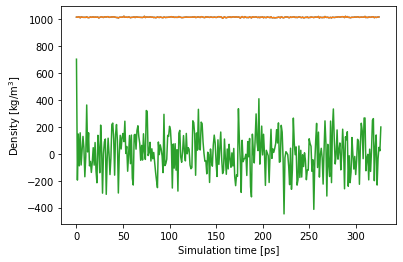

In [42]:
import matplotlib.pyplot as plt
%matplotlib inline

time,dens = get_prop("density")
plt.plot(time,dens)

plt.xlabel('Simulation time [ps]')
plt.ylabel('Density [kg/m$^3$]')
plt.plot(time,dens)

time,pres = get_prop("pressure")
plt.plot(time,pres)

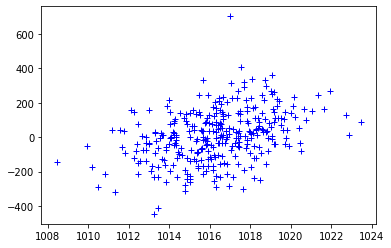

In [43]:
plt.plot(dens,pres[:len(dens)],'b+')

References:
    1. Slurm-magin
        https://github.com/NERSC/slurm-magic
    2. Using Jupyter Notebooks to manage SLURM jobs
    https://www.kth.se/blogs/pdc/2019/01/using-jupyter-notebooks-to-manage-slurm-jobs/
        
    3. GROMACS tutorial
    http://www.mdtutorials.com/gmx/lysozyme/index.html
        
    4. Using Jupyter Notebooks to manage SLURM jobs
    https://www.kth.se/blogs/pdc/2019/01/using-jupyter-notebooks-to-manage-slurm-jobs/